In [8]:
# Librerias
import os
from bs4 import BeautifulSoup
from unidecode import unidecode
import datetime
import traceback
import json
import csv
import pandas as pd
import jellyfish
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [9]:
# Parámetros
inputFolder = "1-input"
processFolder = "2-process"
outputFolder = "3-output"
otherOutputFolder = "../3-modelling/1-input/"
logsFolder = "4-logs"

inputMainFolder = inputFolder + r"\main"
inputMastersFolder = inputFolder + r"\masters"

processMainFolder = processFolder + r"\main"
processSupportFolder = processFolder + r"\support"

dataVisualizationTopLimit = 20

In [10]:
# Funciones utilitarias
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

def find_nth_right(haystack, needle, n):
    start = haystack.rfind(needle)
    while start >= 0 and n > 1:
        start = haystack.rfind(needle, 0, start-len(needle))
        n -= 1
    return start

def parseLineBreaksAndAccents(text):
  return unidecode(" ".join(text.split()))

def parseNames(text):
  return text.strip().title()

def findTags(tag, color):
  return tag.find("span", {"style": 'font-size:10.0pt;font-family:"Arial",sans-serif;mso-fareast-font-family:\n"Times New Roman";color:' + color })

def getChildIndex(mainChildTags, title, color):
  return next((index for index, tag in enumerate(mainChildTags) if ( parseNames(parseLineBreaksAndAccents(findTags(tag, color).text)) == title if findTags(tag, color) else False )), None)

def getSectionsIndexes(mainChildTags, color):
  sectionsIndexes = []
  sectionsTitle = ["Objetivo Laboral", "Experiencia Laboral", "Educacion", "Informatica", "Idiomas", "Otros Conocimientos"]
  
  for sectionTitle in sectionsTitle:
    sectionIndex = getChildIndex(mainChildTags, sectionTitle, color)
    sectionsIndexes.append(sectionIndex)
  
  sectionsIndexes.append(len(mainChildTags)-1)
  return sectionsIndexes

def getNextSectionIndexValid(sectionsIndexes, i):
  while(not sectionsIndexes[i]):
    i = i + 1

  return sectionsIndexes[i]

def getStartAndEndIndex(sectionsIndexes, i):
  return sectionsIndexes[i], getNextSectionIndexValid(sectionsIndexes, i+1)

def readJson(path, encoding='utf-8', errors=None):
  with open (path, "r", encoding=encoding, errors=errors) as f:
    data = json.loads(f.read())
  return data

def writeJson(data, pathJson, encoding='utf-8'):
  with open(pathJson, 'w', encoding=encoding) as f:
    json.dump(data, f, indent=4, ensure_ascii=False)

def writeCsv(data, pathCsv, encoding='utf-8'):
  with open(pathCsv, 'w', newline='', encoding=encoding) as f:
    if data:
      writer = csv.DictWriter(f, fieldnames=data[0].keys(), lineterminator='\n')
      writer.writeheader()
      writer.writerows(data)
    else:
      f.write("")

def writeTxt(data, pathTxt, encoding='utf-8'):
  with open(pathTxt, 'w', encoding=encoding) as f:
    f.write(data)

def readAndWriteSupport(folder, file, writeFileName, readEncoding = 'utf-8', writeEncoding = 'utf-8'):
  with open(os.path.join(folder, file), "r", encoding=readEncoding) as file:
    data = [{k: parseNames(v) for k, v in row.items()} for row in csv.DictReader(file, skipinitialspace=True)]

  with open(os.path.join(processSupportFolder, writeFileName), 'w', encoding=writeEncoding) as file:
    json.dump(data, file, indent=4, ensure_ascii=False)
  
  return data

def readAndWriteInHome(folder, writeFileName):
  folderFiles = [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

  attendees = []
  
  for file in folderFiles:
    # Detectar si tienen el To: en el texto
    try:
      # Detectar el encoding
      encoding = "utf-16"
      with open(file, "r") as f:
        encoding = 'windows-1252' if "charset=windows-1252" in f.read() else 'utf-16'

      # El .read() manda el cursor al final del archivo, por eso si se usa 2 veces, la 2da vez no encuentra nada
      with open(file, "r", encoding=encoding) as f:
        soup = BeautifulSoup(f.read(), "lxml")
        if '<span style="color:black">To:<span style="mso-tab-count:1">' in parseLineBreaksAndAccents(str(soup)):
          emailAttendeesText = parseLineBreaksAndAccents(soup.find_all("span", {"style": 'color:black'})[5].text)
          emailAttendeesList = emailAttendeesText.split("; ")
          for emailAttendee in emailAttendeesList:
            if emailAttendee not in attendees:
              attendees.append(emailAttendee)
    except Exception as e:
      print(file)
      traceback.print_exc()
      print()
      pass

  data = [ {"name": parseNames(participant)} for participant in attendees ]

  with open(os.path.join(processSupportFolder, writeFileName), 'w', encoding='utf-8') as file:
    json.dump(data, file, indent=4, ensure_ascii=False)

  return data

def getCompare(data, fields):
  return (list(set([" ".join(x for x in [elem[y] for y in fields] if x) for elem in data if elem])))

def readCsv(file, readEncoding = 'utf-8'):
  with open(os.path.join(file), "r", encoding=readEncoding) as file:
    data = [{k: parseNames(v) for k, v in row.items()} for row in csv.DictReader(file, skipinitialspace=True)]

  return data

def showMissingValues(df):
  percentMissing = df.isnull().sum() * 100 / len(df)
  missingValueDf = pd.DataFrame({'columnName': df.columns, 'percentMissing': percentMissing })
  missingValueDf = missingValueDf.sort_values('percentMissing', ascending=False).reset_index(drop=True)
  display(missingValueDf)

In [11]:
def readAndWritePreprocessedData(preprocessedData, masters):
  ## Decisiones propias para el modelo

  # Transformar la data a dataframe
  df = pd.DataFrame(preprocessedData)

  for i in range(0, len(masters)):
    masters[i] = pd.DataFrame(masters[i])

  # Eliminar los campos que ya no se usarán
  columnsToDelete = [
    "candidatePostulationDate", "jobId", "candidateFullName", "candidateDocumentNumber", "candidateBirthDate", "candidateAddress", "candidateHomeNumber", "candidateCellphoneNumber", "candidateEmail", "workObjetive", "lastWorkDays", "lastWorkDescription", "lastEducationDays"
  ]
  # El tema con las ultimas 2 es que puede ser 0 cuando hay o no data de experiencia y educacion, reemplazar el NaN desde el comienzo en el dataframe (understanding)
  df = df.drop(columns=columnsToDelete)

  # Aplicar las equivalencias a los campos: jobProfileName, lastWorkCompany, lastWorkArea, lastWorkName, lastEducationCompany, lastEducationArea, lastEducationName
  equivalences = ["jobProfileName", "lastWorkCompany", "lastWorkName", "lastEducationCompany", "lastEducationName"]

  # Mejorar las equivalencias poco a poco
  for index, equivalence in enumerate(equivalences):
    df = pd.merge(df, masters[index], on=equivalence)
    df[equivalence] = df["equivalence"]
    df = df.drop(columns=["equivalence", "count", "equals"])

  ## Decisiones por la metodología

  # Analisis de valores nulos
  # Reemplazando las cadenas vacias a NaN
  categoricalColumns = [columnName for columnName, columnType in df.dtypes.to_dict().items() if columnName not in [ "hired" ] and columnType == "object" ]
  for column in categoricalColumns:
    df[column] = df[column].replace('',None,regex = True).astype("object")

  # Reemplazando los ceros a NaN
  numericalColumns = [columnName for columnName, columnType in df.dtypes.to_dict().items() if columnName not in [ "hired" ] and columnType == "float64" ]
  for column in numericalColumns:
    df[column] = df[column].replace(0,None).astype('float64')

  # Obteniendo el porcentaje de nulos por columna
  showMissingValues(df)
  
  # Tecnica 1: Eliminar la columna si sobrepasa el 30% de nulos
  # Al ninguno superar el 30% de nulos, no se eliminará ninguna columna

  # Tecnica 2: Reemplazar NaN por aleatorizacion de valores no nulos, para variables categoricas
  np.random.seed(0)

  for column in categoricalColumns:
    df[column] = df[column].map(lambda x: x if not pd.isna(x) else np.random.choice(df[column].dropna().tolist()))

  # Tecnica 3: Reemplazar NaN por el promedio de valores no nulos, para variables numericas
  for column in numericalColumns:
    df[column] = df[column].map(lambda x: x if not pd.isna(x) else round(float(df[column].dropna().mean()), 1) )

  # Obteniendo el nuevo porcentaje de nulos por columna
  showMissingValues(df)

  # Reemplazo de valores atipicos (outliers) (variables numericas)
  # Analizando valores atipicos extremos
  for column in numericalColumns:
    firstQuartil, thirdQuartil = np.percentile(df[column], 25), np.percentile(df[column], 75)
    interQuartilRange = thirdQuartil - firstQuartil
    bottomLimit, topLimit = firstQuartil - 3*interQuartilRange, thirdQuartil + 3*interQuartilRange

    # Reemplazando los valores
    df[column] = df[column].map(lambda x: bottomLimit if x < bottomLimit else x)
    df[column] = df[column].map(lambda x: topLimit if x > topLimit else x)

  # Regresando el dataframe a array de dicts
  preprocessedData = df.to_dict('records')

  writeJson(preprocessedData, os.path.join(outputFolder, 'result.json'), 'utf-8')
  writeCsv(preprocessedData, os.path.join(outputFolder, 'result.csv'), 'utf-8')

  writeJson(preprocessedData, os.path.join(otherOutputFolder, 'result.json'), 'utf-8')
  writeCsv(preprocessedData, os.path.join(otherOutputFolder, 'result.csv'), 'utf-8')

  return preprocessedData

In [12]:
def visualizeData(mergedMainData):
  df = pd.DataFrame(mergedMainData)

  print(df.dtypes)
  print(df.count())

  columns = [columnName for columnName in df.columns]
  categoricalColumns = [columnName for columnName, columnType in df.dtypes.to_dict().items() if columnName not in [ "hired" ] and columnType == "object" ]
  numericalColumns = [columnName for columnName, columnType in df.dtypes.to_dict().items() if columnName not in [ "hired" ] and columnType == "float64" ]

  for column in columns:
    if column in numericalColumns:
      topDf = df[column].value_counts().head(dataVisualizationTopLimit)
      print(topDf)
      y_axis = list(reversed(topDf.index))
      x_axis = list(reversed(topDf.values))
      plt.ylabel(column)
      plt.barh(y_axis, x_axis)
      plt.show()
    else:
      topDf = df[column].value_counts().head(dataVisualizationTopLimit)
      print(topDf)
      y_axis = list(reversed(topDf.index))
      x_axis = list(reversed(topDf.values))
      plt.ylabel(column)
      plt.barh(y_axis, x_axis)
      plt.show()

In [13]:
def main():
  # Definiendo el inicio del proceso
  startTime = datetime.datetime.now()
  print("Inicio: " + str(startTime))
  print("Se inició el procesamiento")

  isPreprocessed = False

  # Leyendo la data obtenida en el entendimiento de los datos
  bumeranData = readJson(os.path.join(inputMainFolder, 'result.json'))
  
  # Leyendo archivos maestros
  jobProfileName = readCsv(os.path.join(inputMastersFolder, 'jobProfileName.csv'))
  lastWorkCompany = readCsv(os.path.join(inputMastersFolder, 'lastWorkCompany.csv'))
  lastWorkName = readCsv(os.path.join(inputMastersFolder, 'lastWorkName.csv'))
  lastEducationCompany = readCsv(os.path.join(inputMastersFolder, 'lastEducationCompany.csv'))
  lastEducationName = readCsv(os.path.join(inputMastersFolder, 'lastEducationName.csv'))

  # Aplicando los datos de los maestros y validaciones
  preprocessedData = readJson(os.path.join(outputFolder, 'result.json')) if isPreprocessed else readAndWritePreprocessedData(bumeranData, [jobProfileName, lastWorkCompany, lastWorkName, lastEducationCompany, lastEducationName])
  print("Se terminó el preprocesamiento")

  visualizeData(preprocessedData)

  # Definiendo el fin del proceso
  endTime = datetime.datetime.now()
  print("Fin: " + str(endTime))
  print("Tiempo: " + str(endTime-startTime))

Inicio: 2023-05-25 03:20:00.245227
Se inició el procesamiento


,columnName,percentMissing
0,otherSkills,22.864962
1,technicalSkills,11.795791
2,languages,7.426630
3,candidateCivilStatus,5.982825
4,lastWorkCompany,5.435501
5,yearsOfExperience,5.426064
6,lastWorkName,5.360008
7,worksNumber,5.360008
8,lastWorkArea,5.360008
9,lastWorkCountry,5.360008


,columnName,percentMissing
0,jobProfileName,0.0
1,lastEducationCountry,0.0
2,otherSkills,0.0
3,languages,0.0
4,technicalSkills,0.0
5,studiesNumber,0.0
6,yearsOfStudy,0.0
7,lastEducationDegree,0.0
8,lastEducationStatus,0.0
9,lastEducationName,0.0


Se terminó el preprocesamiento
jobProfileName                object
candidateResidenceCountry     object
candidateCivilStatus          object
candidateBirthCountry         object
salary                       float64
lastWorkCompany               object
lastWorkCountry               object
lastWorkArea                  object
lastWorkName                  object
yearsOfExperience            float64
worksNumber                  float64
lastEducationCompany          object
lastEducationCountry          object
lastEducationArea             object
lastEducationName             object
lastEducationStatus           object
lastEducationDegree           object
yearsOfStudy                 float64
studiesNumber                float64
technicalSkills              float64
languages                    float64
otherSkills                  float64
hired                          int64
dtype: object
jobProfileName               10597
candidateResidenceCountry    10597
candidateCivilStatus         10597

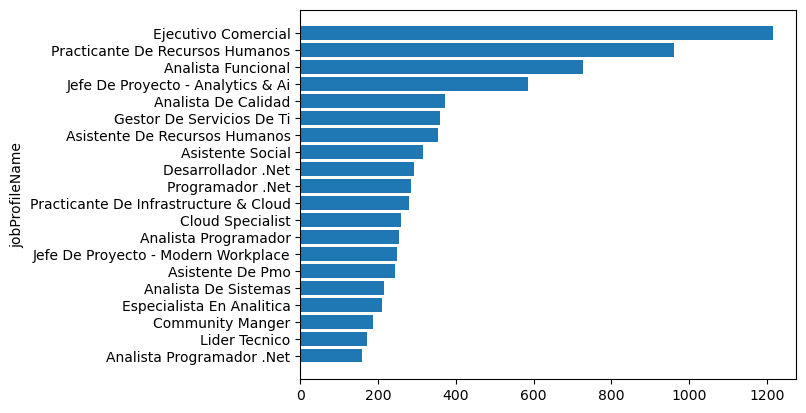

Peru                    10412
Venezuela                 148
Argentina                  11
Colombia                    9
Brasil                      4
Ecuador                     3
Chile                       2
Republica Dominicana        2
El Salvador                 1
Panama                      1
Espana                      1
Costa Rica                  1
Francia                     1
Bolivia                     1
Name: candidateResidenceCountry, dtype: int64


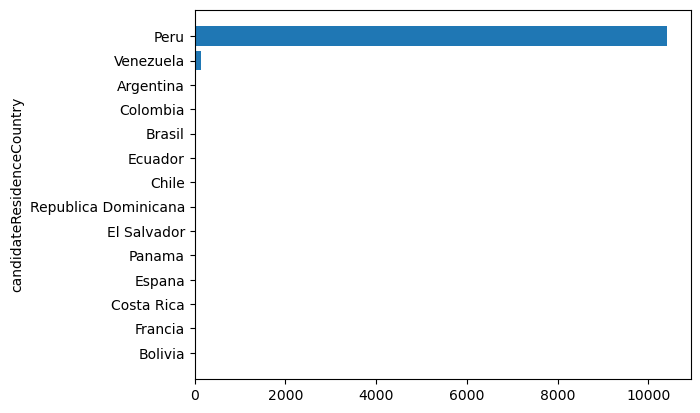

Soltero/A          8638
Casado/A           1654
Divorciado/A        136
Pareja De Hecho     118
Union Libre          48
Viudo/A               3
Name: candidateCivilStatus, dtype: int64


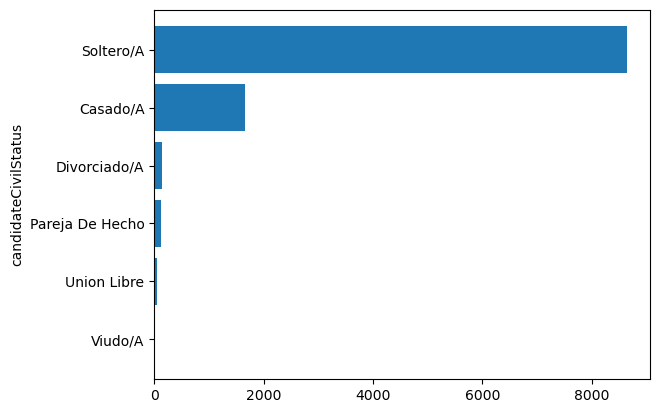

Peru                    10410
Venezuela                 149
Argentina                  12
Colombia                    9
Brasil                      4
Ecuador                     3
Chile                       2
Republica Dominicana        2
El Salvador                 1
Panama                      1
Espana                      1
Costa Rica                  1
Francia                     1
Bolivia                     1
Name: candidateBirthCountry, dtype: int64


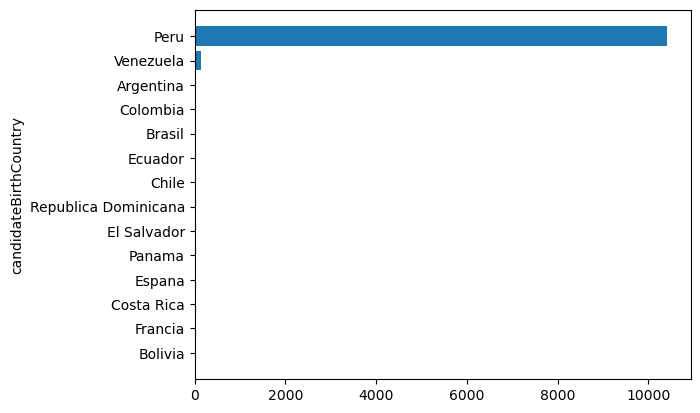

5000.0    641
2500.0    639
2000.0    601
3500.0    593
3000.0    574
4000.0    560
1500.0    484
6000.0    463
4301.8    439
4500.0    434
1200.0    364
1800.0    360
5500.0    326
6500.0    305
1025.0    298
7000.0    296
1000.0    282
930.0     227
1.0       210
8000.0    208
Name: salary, dtype: int64


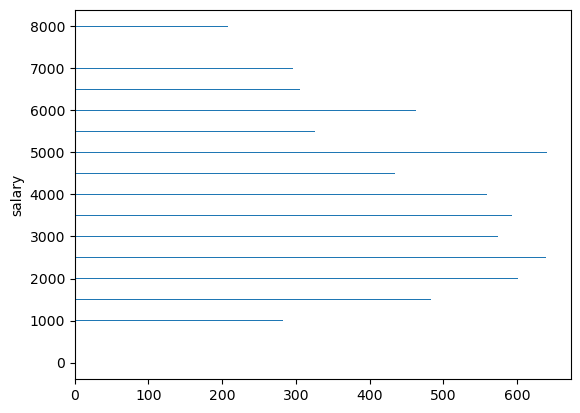

Freelance                                          224
Ntt Data Peru S.A.C.                               186
Canvia S.A.C.                                      179
Global Hitss Peru S.A.C.                           132
Mdp Consulting S.A.C.                              127
Manpower Professional Services S.A.                116
Indra Peru S.A.                                    100
Telefonica Del Peru                                 90
Banco De Credito Del Peru - Bcp                     87
Stefanini It Solutions                              78
Tata Consultancy Services                           63
Corporacion Sapia S.A.                              57
Universidad Peruana De Ciencias Aplicadas (Upc)     50
Tgestiona Sac                                       43
Ferreyros S.A.                                      42
America Movil Peru S.A.C.                           41
Oficina Nacional De Procesos Electorales (Onpe)     40
Pontificia Universidad Catolica Del Peru            39
Gfi Peru S

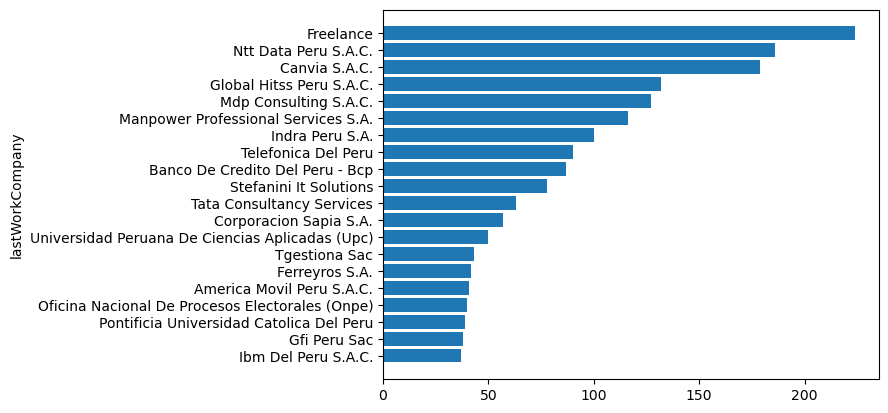

Peru              10404
Estados Unidos       33
Espana               31
Venezuela            25
Brasil               19
Colombia             17
Chile                15
Argentina             9
Ecuador               7
Mexico                4
Reino Unido           3
Costa Rica            3
Albania               3
Italia                2
Panama                2
Finlandia             2
Australia             2
Paises Bajos          2
Francia               2
Honduras              1
Name: lastWorkCountry, dtype: int64


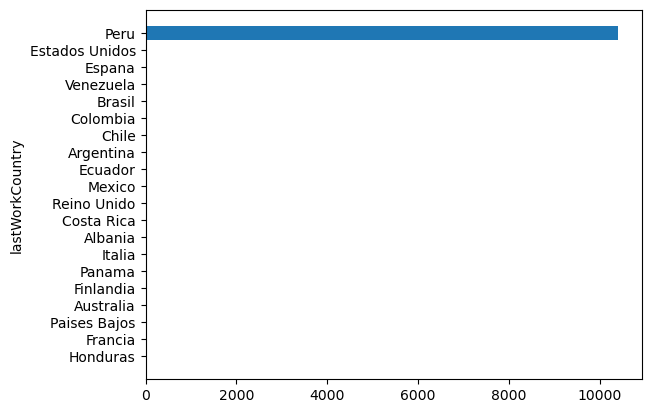

Tecnologia / Sistemas            1165
Tecnologias De La Informacion    1118
Liderazgo De Proyecto             646
Programacion                      624
Comercial                         595
Sistemas                          533
Recursos Humanos                  479
Analisis Funcional                316
Ventas                            283
Administracion                    279
Analisis De Datos                 266
Infraestructura                   223
Soporte Tecnico                   215
Atencion Al Cliente               178
Seguridad Informatica             172
Otras Ingenierias                 163
Testing / Qa / Qc                 145
Desarrollo De Negocios            135
Telecomunicaciones                129
Administracion De Personal        125
Name: lastWorkArea, dtype: int64


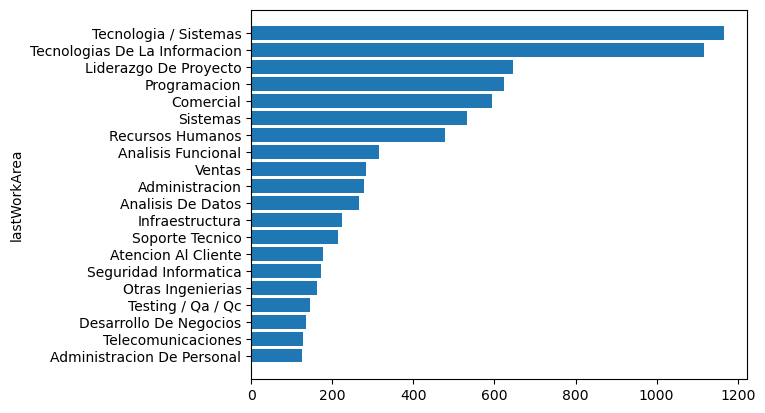

Analista Programador                            595
Analista De Sistemas                            295
Analista Funcional                              250
Jefe De Proyectos                               191
Asistente Administrativo                        128
Analista De Calidad                             121
Trabajadora Social                              116
Ejecutivo Comercial                             102
Asistente De Recursos Humanos                    96
Project Manager                                  91
Supervisor De Infraestructura De Redes Cisco     89
Docente                                          84
Practicante Profesional                          81
Practicante Pre Profesional                      74
Asesor Comercial                                 74
Lider Tecnico                                    72
Soporte Tecnico                                  69
Gestor De Proyectos                              67
Gerente De Proyectos                             63
Practicante 

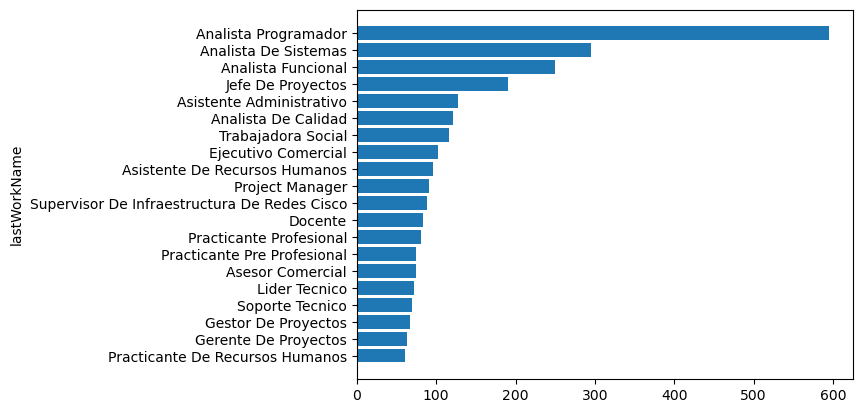

8.7     645
4.8     106
4.3     106
8.8      98
5.8      94
0.2      93
2.8      91
1.9      90
6.8      88
32.9     85
5.9      85
7.3      83
8.4      83
7.7      83
1.2      81
1.0      79
0.5      79
7.0      79
8.3      79
6.3      79
Name: yearsOfExperience, dtype: int64


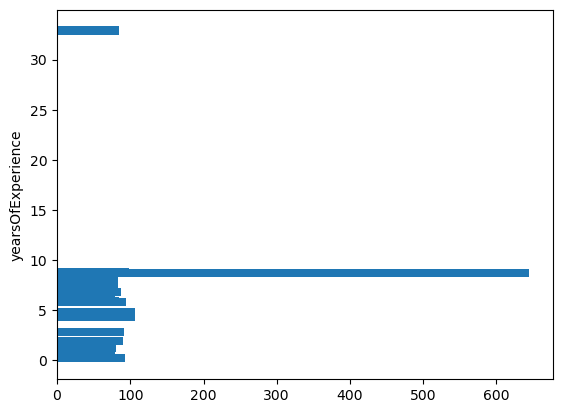

5.0     1335
4.0     1229
6.0     1113
3.0     1050
7.0      984
8.0      758
2.0      749
1.0      672
6.1      568
9.0      558
10.0     422
11.0     289
12.0     251
13.0     157
14.0     128
15.0      99
17.0      63
20.0      52
16.0      48
19.0      40
Name: worksNumber, dtype: int64


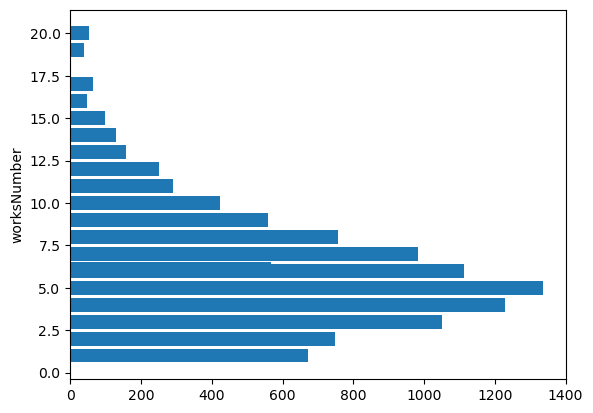

Universidad Peruana De Ciencias Aplicadas    946
Universidad Tecnologica Del Peru             547
Instituto Cibertec                           450
Pontificia Universidad Catolica Del Peru     364
Universidad Privada Del Norte                356
Universidad San Ignacio Del Loyola           340
Universidad Nacional Mayor De San Marcos     336
Universidad Cesar Vallejo                    308
Universidad Esan                             300
Universidad De Lima                          256
Universidad Nacional De Ingenieria           227
Universidad De San Martin De Porres          222
Universidad Ricardo Palma                    201
Universidad Nacional Federico Villarreal     197
Instituto San Ignacio De Loyola              187
Universidad Inca Garcilaso De La Vega        186
Tecsup                                       129
Instituto Superior Tecnologico Idat          126
Universidad Del Pacifico                     119
Universidad Alas Peruanas                    105
Name: lastEducationC

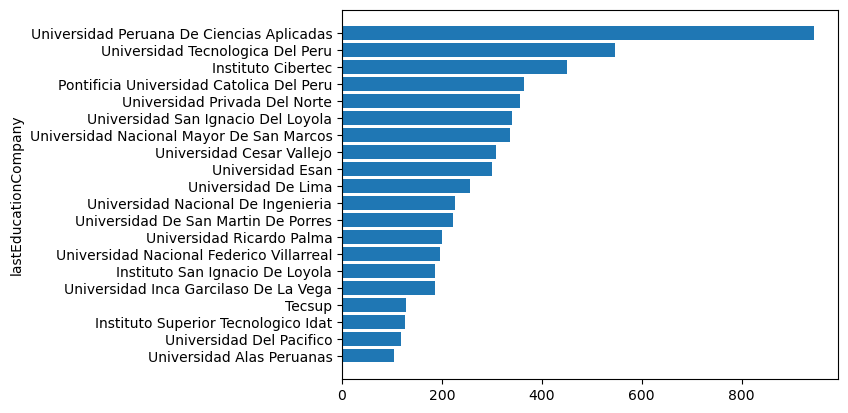

Peru              9965
Espana             205
Venezuela          166
Estados Unidos      78
Mexico              34
Argentina           23
Colombia            20
Brasil              19
Chile               18
Costa Rica          14
Canada               9
Australia            6
Ecuador              6
Bolivia              6
Francia              5
Alemania             3
Reino Unido          3
India                3
Internacional        2
Cuba                 2
Name: lastEducationCountry, dtype: int64


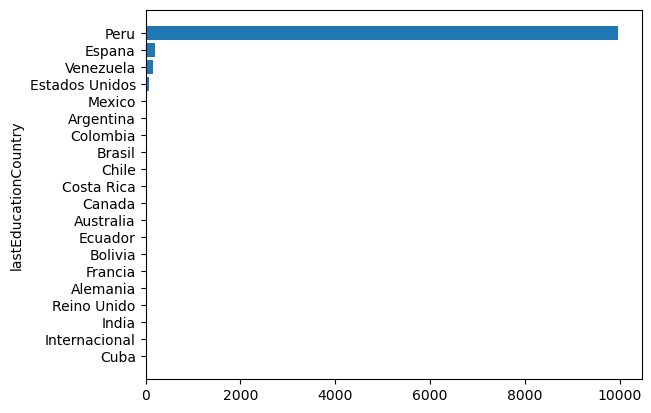

Ing. En Sistemas                  2462
Tecnologias De La Informacion     1318
Adm. De Empresas                  1187
Ing. Informatica                   660
Ing. Industrial                    521
Computacion / Informatica          501
Marketing / Comercializacion       377
Recursos Humanos / Relac. Ind.     365
Otra                               362
Psicologia                         355
Ing. - Otros                       206
Trabajo Social                     163
Analisis De Sistemas               153
Ing. Telecomunicaciones            132
Programacion                       123
Telecomunicaciones                 122
Procesos / Calidad Total           116
Finanzas                           101
Bachiller                           98
Ing. Electronica                    97
Name: lastEducationArea, dtype: int64


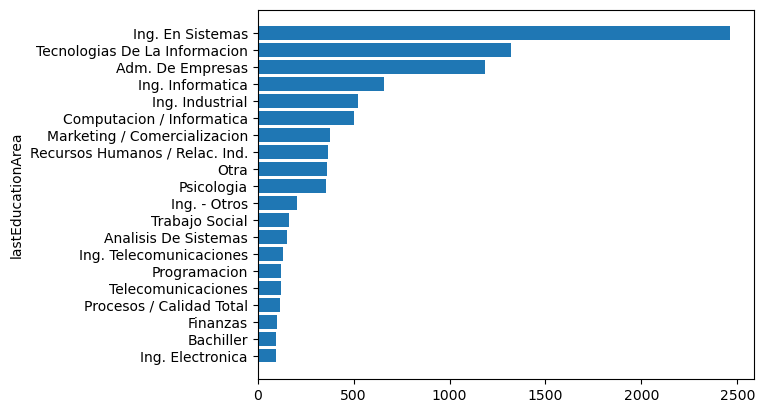

Ingenieria De Sistemas                       1686
Ingenieria Industrial                         346
Psicologia                                    313
Administracion De Empresas                    234
Computacion E Informatica                     182
Mba                                           145
Bachiller En Ingenieria De Sistemas           138
Administracion                                130
Marketing                                     125
Administracion Y Negocios Internacionales      98
Ingles                                         87
Scrum Master                                   85
Itil                                           78
Gestion De Proyectos                           76
Trabajo Social                                 71
Ingenieria Informatica                         64
Ingenieria De Redes Y Comunicaciones           61
Tecnico En Computacion E Informatica           57
Ingenieria De Software                         56
Ingenieria De Computacion Y Sistemas           55


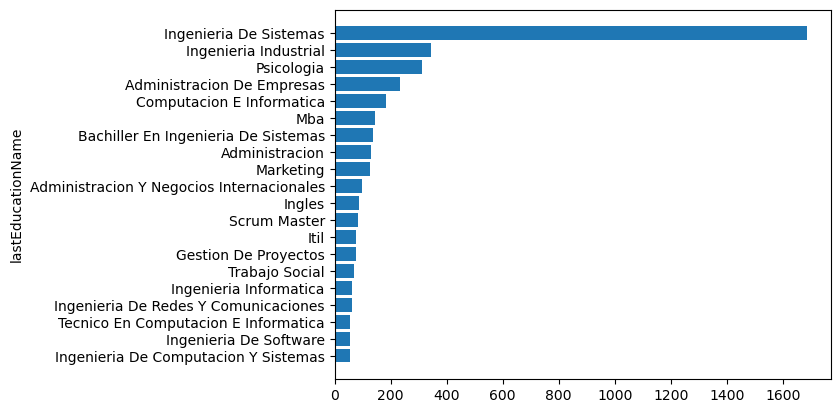

Graduado      6976
En Curso      3441
Abandonado     180
Name: lastEducationStatus, dtype: int64


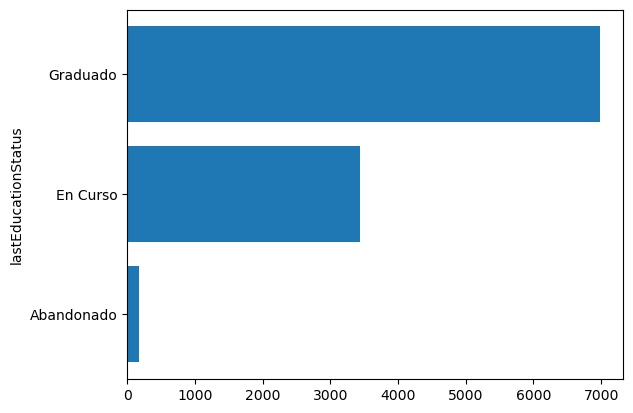

Universitario        5232
Otro                 2386
Posgrado             1274
Terciario/Tecnico    1048
Master                632
Doctorado              14
Secundario             11
Name: lastEducationDegree, dtype: int64


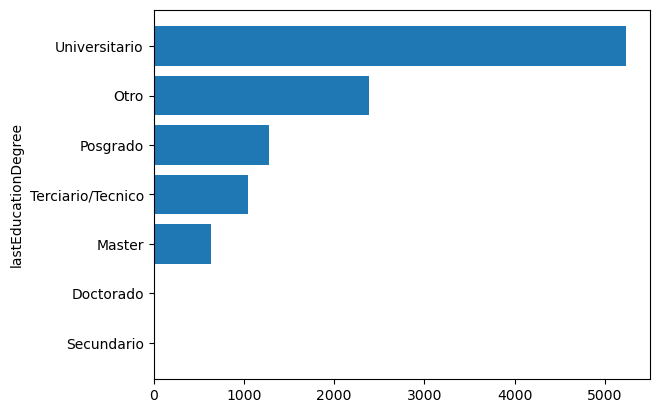

5.3     330
4.8     329
6.3     279
5.8     256
7.7     253
4.7     245
5.0     208
6.8     204
4.9     200
7.8     182
5.9     179
5.7     178
21.0    173
5.4     163
7.3     162
7.4     154
6.5     149
4.5     140
8.3     133
6.9     129
Name: yearsOfStudy, dtype: int64


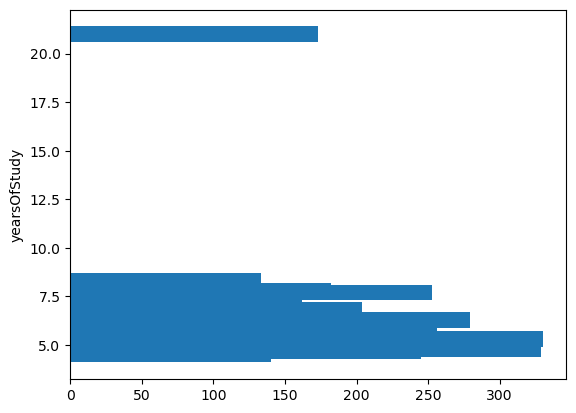

1.0     3918
2.0     2440
3.0     1217
4.0      734
5.0      492
6.0      442
7.0      304
13.0     283
8.0      197
9.0      152
3.2      128
11.0     121
10.0      97
12.0      72
Name: studiesNumber, dtype: int64


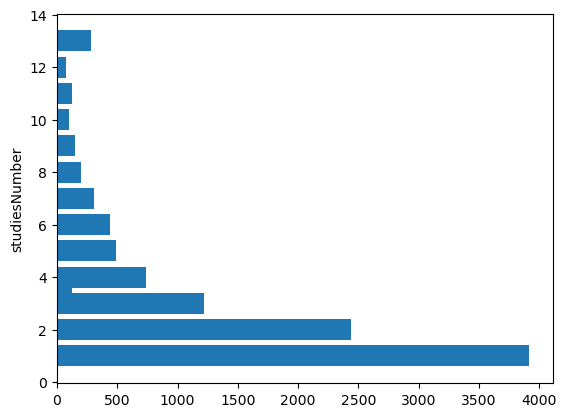

9.4     1250
1.0     1153
3.0      880
2.0      828
4.0      709
5.0      613
6.0      546
7.0      512
9.0      469
8.0      445
11.0     355
10.0     351
35.0     300
12.0     270
13.0     251
16.0     246
14.0     193
15.0     166
17.0     129
18.0     127
Name: technicalSkills, dtype: int64


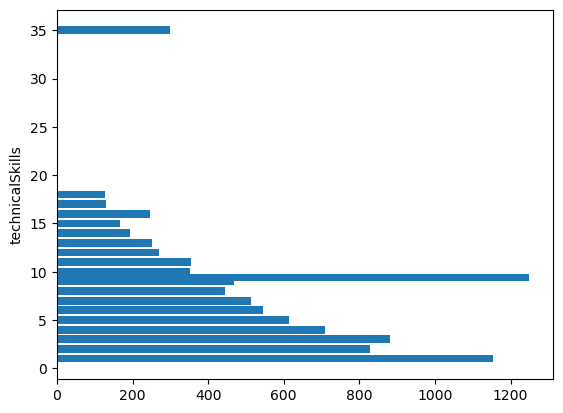

1.0    7381
2.0    2054
1.3     787
2.2     375
Name: languages, dtype: int64


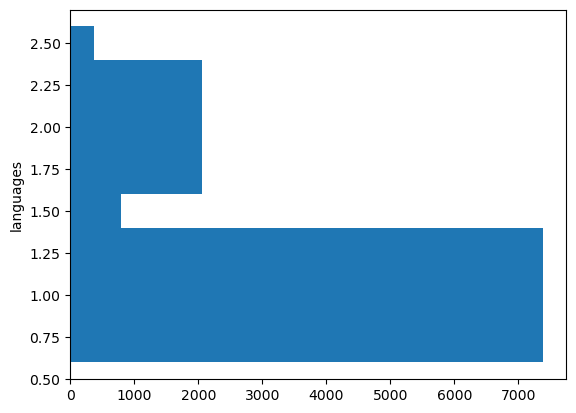

5.4     2423
1.0     1789
2.0     1209
3.0      871
4.0      777
5.0      665
6.0      523
7.0      450
8.0      360
18.0     286
9.0      280
10.0     228
11.0     184
12.0     152
13.0     123
14.0      98
15.0      74
17.0      55
16.0      50
Name: otherSkills, dtype: int64


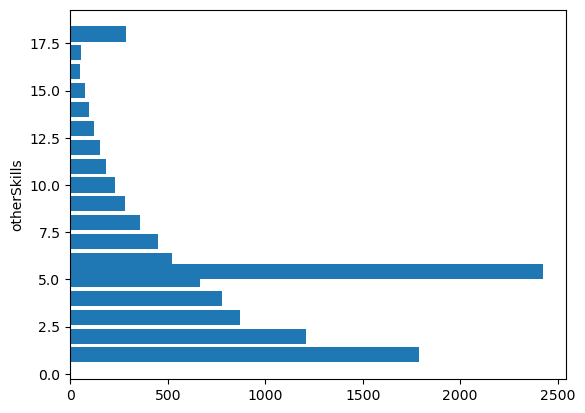

1    7647
0    2950
Name: hired, dtype: int64


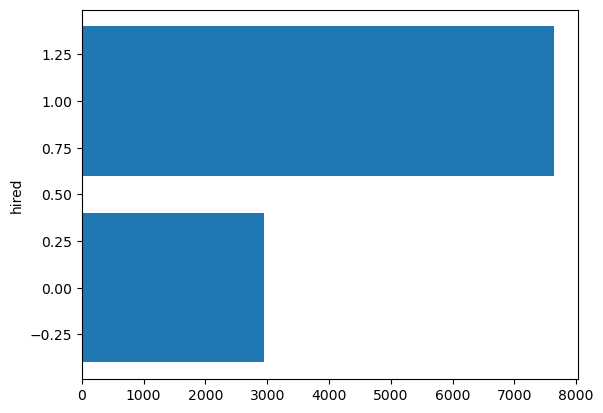

Fin: 2023-05-25 03:20:12.870129
Tiempo: 0:00:12.624902


In [14]:
if __name__ == "__main__":
  main()